## Libraries

In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torchvision.models import alexnet, AlexNet_Weights, AlexNet

from default_config import default_config, default_net_config, default_train_config, data_dir, train_dir, image_size
from convolutionalNetwork import ConvolutionalNetwork
from predict import predict
from plot_scores import plot_scores
from plot_transformations import plot_transformations
from plot_summed_feature_maps import plot_summed_feature_maps
from denormalize_image import denormalize_image
from loaders import get_train_loader
from result_handler import result_handler
from train_model import train_model

## Check device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.__version__

cuda


'2.5.1+cu124'

## Seed

In [3]:
seed = 42

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Explorative Data Analysis

### Dataset walking

In [4]:
for dirpath, dirnames, filenames in os.walk(data_dir):
    if len(dirnames) == 0: # only innermost directories
        print(f"'{dirpath}' directory contains {len(filenames)} images")

'data\test\cats' directory contains 200 images
'data\test\dogs' directory contains 200 images
'data\train\cats' directory contains 1000 images
'data\train\dogs' directory contains 1000 images
'data\validation\cats' directory contains 300 images
'data\validation\dogs' directory contains 300 images


### Labels

In [5]:
print(datasets.ImageFolder(train_dir, transform=transforms.ToTensor()).class_to_idx)

{'cats': 0, 'dogs': 1}


### Plot 10 random images of both cats and dogs

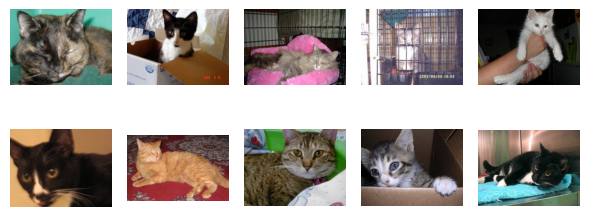

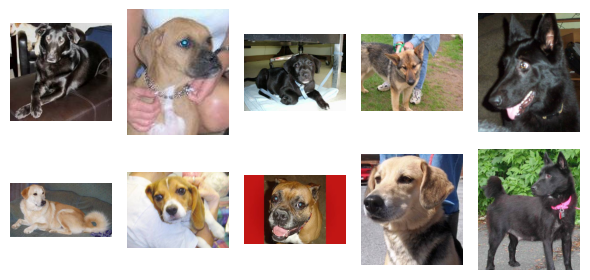

In [6]:
train_cats_dir = f"{train_dir}/cats"
train_dogs_dir = f"{train_dir}/dogs"

cats_images = random.sample([f"{train_cats_dir}/{filename}" for filename in os.listdir(train_cats_dir)], 10)
dogs_images = random.sample([f"{train_dogs_dir}/{filename}" for filename in os.listdir(train_dogs_dir)], 10)

# Plot cat images
fig1, axes1 = plt.subplots(2, 5, figsize=(6, 3))
for i, img in enumerate(cats_images):
    axes1[i // 5, i % 5].imshow(plt.imread(img))
    axes1[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

# Plot dog images
fig2, axes2 = plt.subplots(2, 5, figsize=(6, 3))
for i, img in enumerate(dogs_images):
    axes2[i // 5, i % 5].imshow(plt.imread(img))
    axes2[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

## Transformations

### Use one image as a base

Image size: (500, 374)


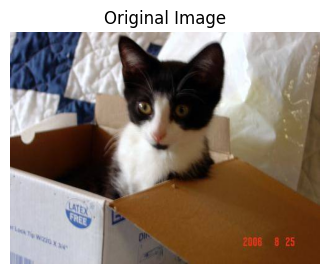

In [7]:
image = Image.open(cats_images[1])

print(f"Image size: {image.size}")

# Plot image_resized
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()

### Image size

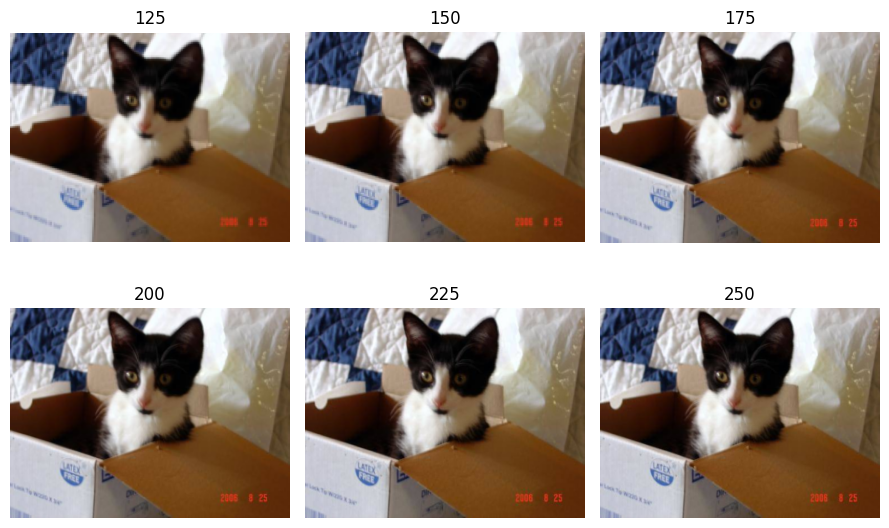

In [8]:
factors = [125, 150, 175, 200, 225, 250]

transformed_images = []
for factor in factors:
    transformed_image = TF.resize(image, factor)
    transformed_images.append(transformed_image)

plot_transformations(transformed_images, factors)

An image size of 225 seems good, however, for compatibility also for pre-trained models we choose 224.

In [9]:
image_resized = TF.resize(image, 224)

### Flip

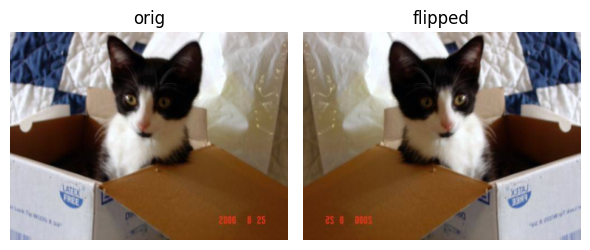

In [10]:
transformed_images = []
transformed_images.append(image_resized)
transformed_images.append(TF.hflip(image_resized))
plot_transformations(transformed_images, ["orig", "flipped"])

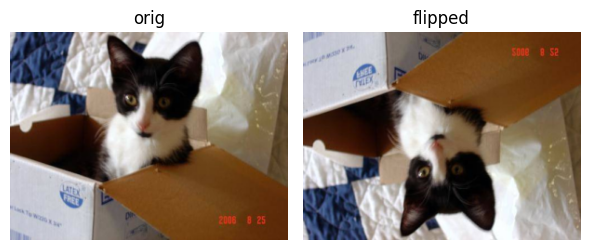

In [11]:
transformed_images = []
transformed_images.append(image_resized)
transformed_images.append(TF.vflip(image_resized))
plot_transformations(transformed_images, ["orig", "flipped"])

Choose to only horizontal flip.

### Image rotation

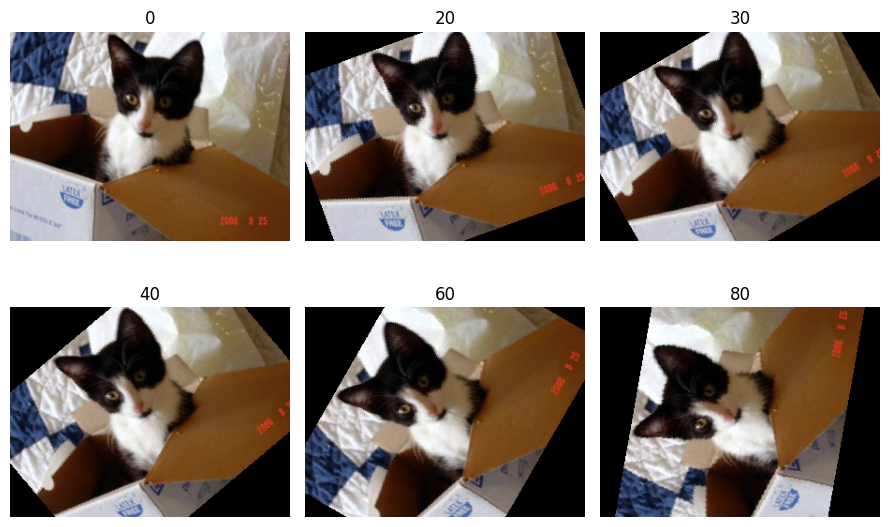

In [12]:
factors = [0, 20, 30, 40, 60, 80]

transformed_images = []
for factor in factors:
    transformed_image = TF.rotate(image_resized, angle=factor)
    transformed_images.append(transformed_image)

plot_transformations(transformed_images, factors)


Choose rotation of 25 degress.

### Cropping

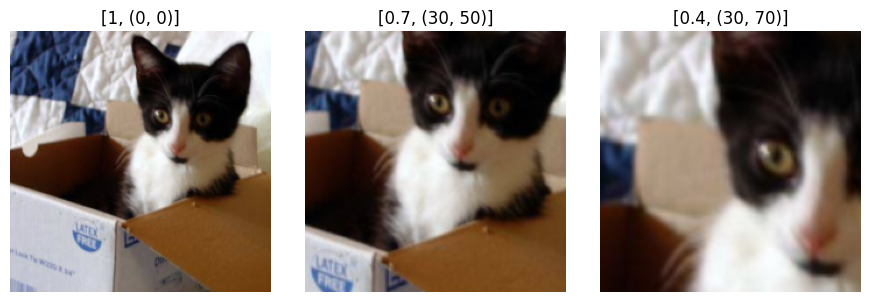

In [13]:
factors = [[1, (0, 0)], [0.7, (30, 50)], [0.4, (30, 70)]]

transformed_images = []
for factor in factors:
    scale = factor[0]
    crop_size = (int(image_size * scale), int(image_size * scale))
    location = factor[1]
    transformed_image = TF.resized_crop(image_resized, location[0], location[1], crop_size[0], crop_size[1], size=(image_size, image_size))
    transformed_images.append(transformed_image)

plot_transformations(transformed_images, factors)

Choose crop scaling of 30%

### Image color

#### Brightness

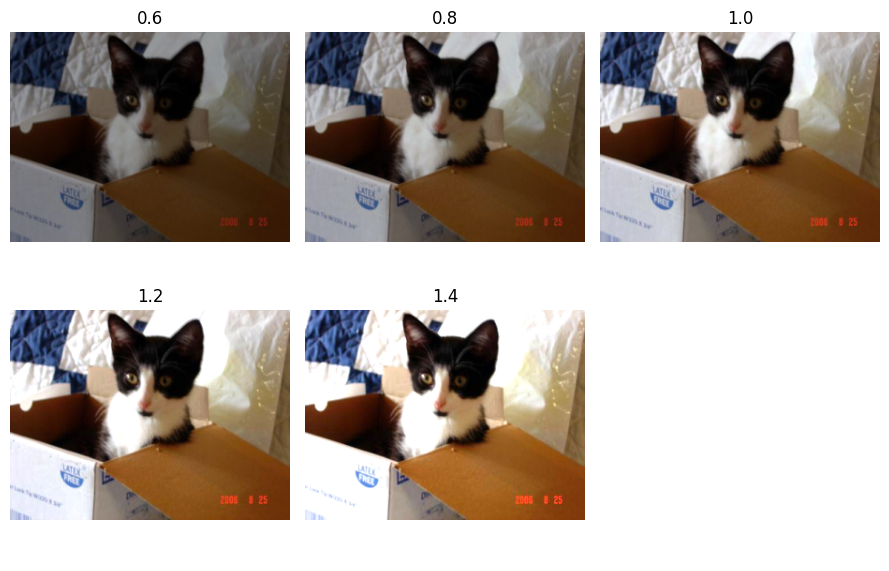

In [14]:
factors = [0.6, 0.8, 1.0, 1.2, 1.4]

transformed_images = []
for factor in factors:
    transformed_image = TF.adjust_brightness(image_resized, factor)
    transformed_images.append(transformed_image)

plot_transformations(transformed_images, factors)

#### Contrast

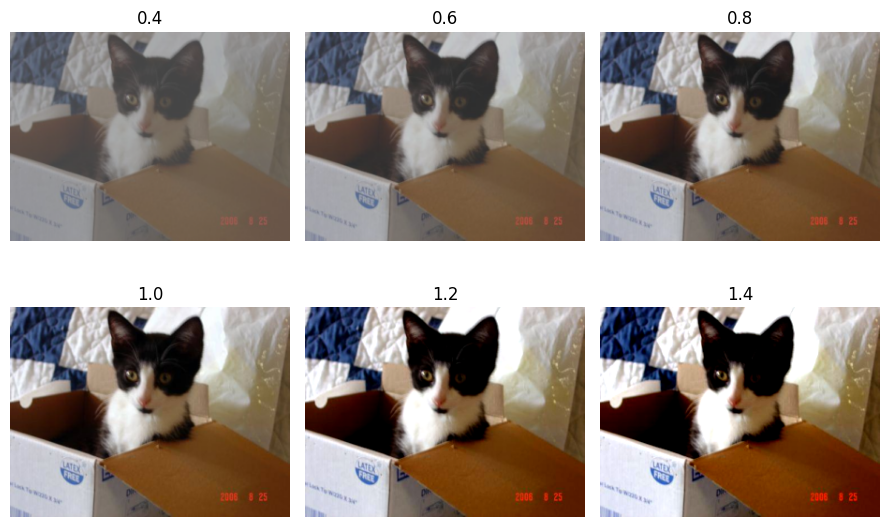

In [15]:
factors = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4]

transformed_images = []
for factor in factors:
    transformed_image = TF.adjust_contrast(image_resized, factor)
    transformed_images.append(transformed_image)

plot_transformations(transformed_images, factors)

#### Saturation

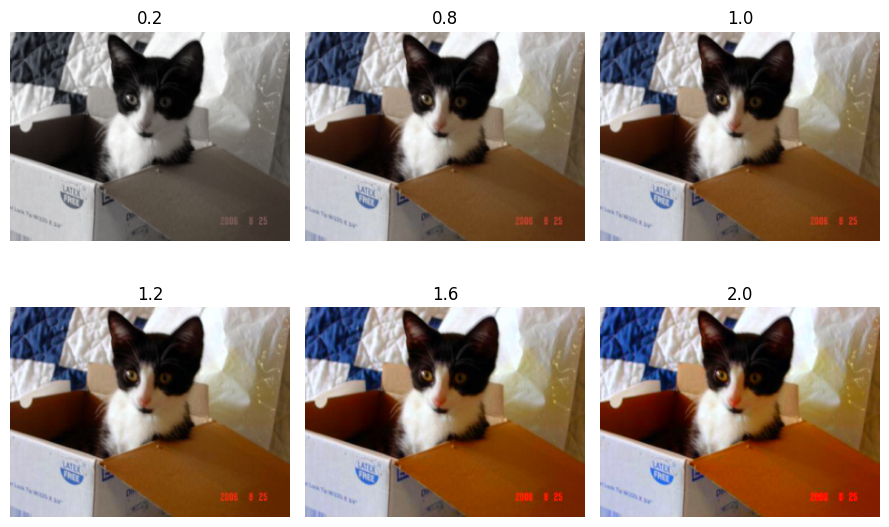

In [16]:
factors = [0.2, 0.8, 1.0, 1.2, 1.6, 2.0]

transformed_images = []
for factor in factors:
    transformed_image = TF.adjust_saturation(image_resized, factor)
    transformed_images.append(transformed_image)

plot_transformations(transformed_images, factors)

#### Hue

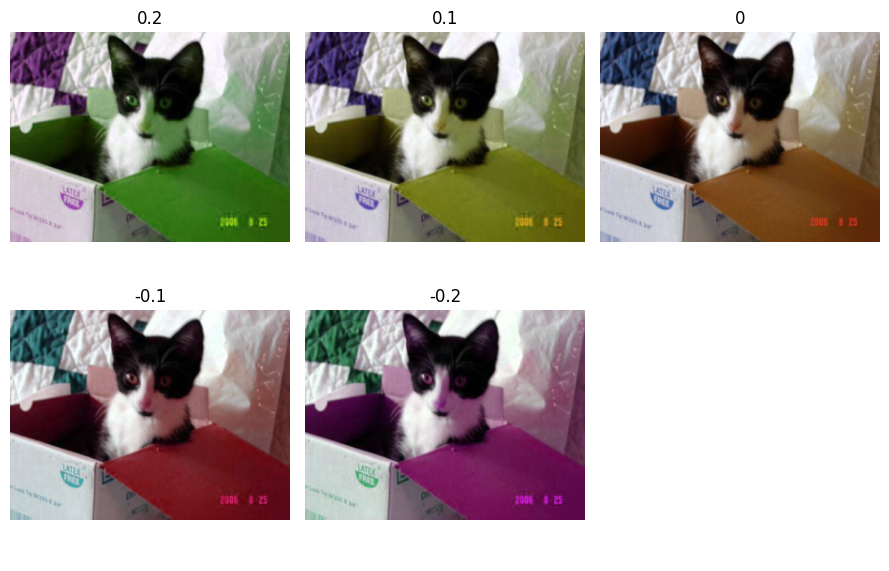

In [17]:
factors = [0.2, 0.1, 0, -0.1, -0.2]

transformed_images = []
for factor in factors:
    transformed_image = TF.adjust_hue(image_resized, factor)
    transformed_images.append(transformed_image)

plot_transformations(transformed_images, factors)

### Affine (rotation, scaling, translation, shearing)

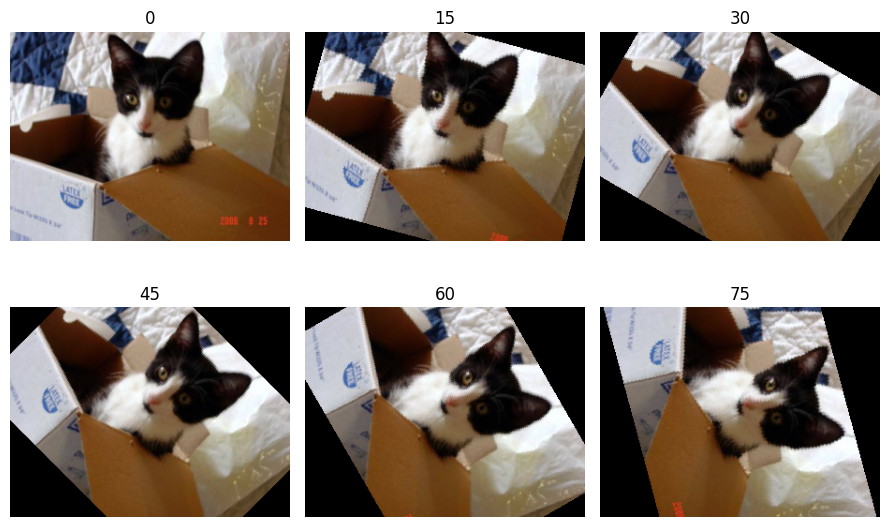

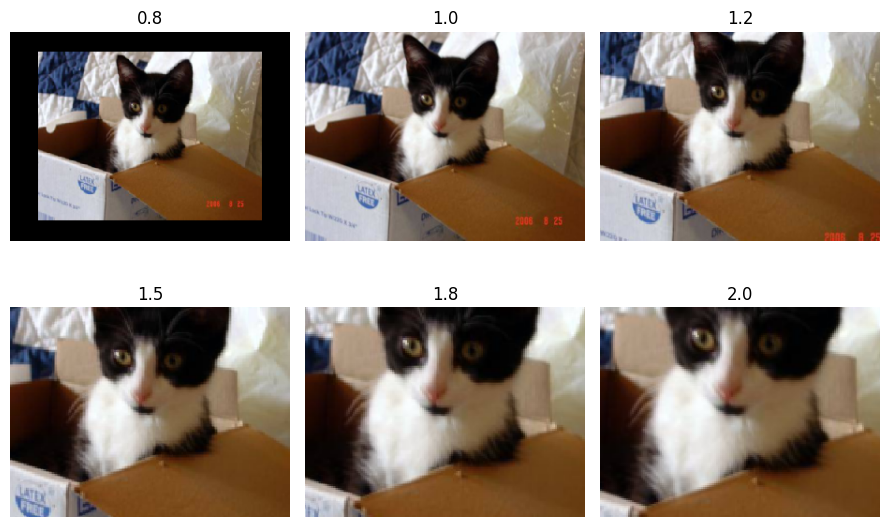

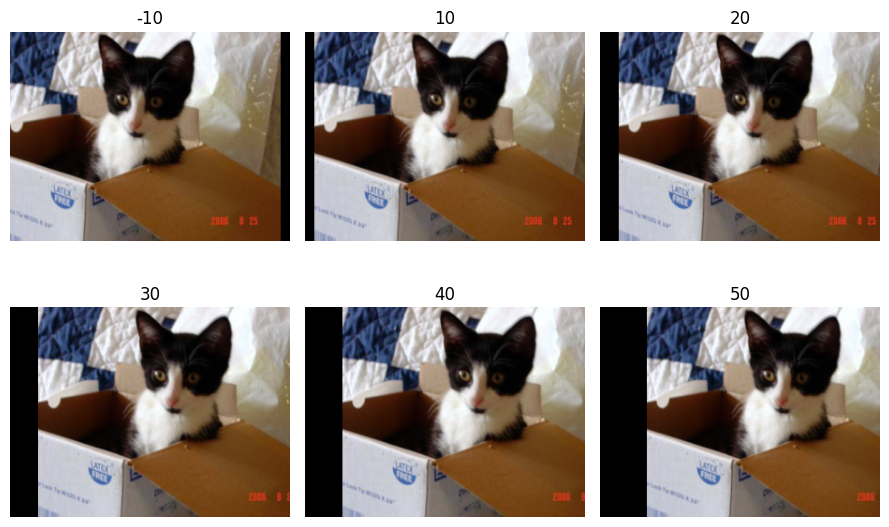

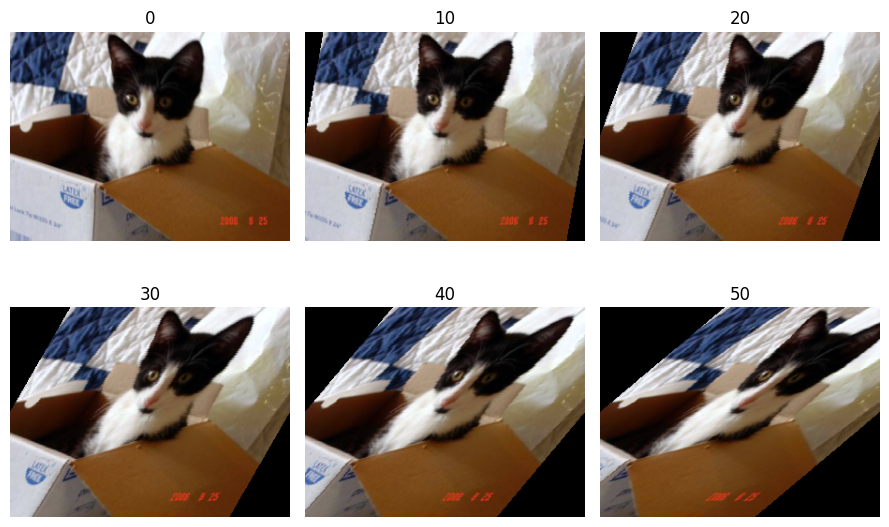

In [18]:
def apply_affine(image, angle, translate=(0, 0), scale=1.0, shear=0):
    return TF.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)

# Rotation
angles = [0, 15, 30, 45, 60, 75]
transformed_images = [apply_affine(image_resized, angle=angle) for angle in angles]
plot_transformations(transformed_images, angles)

# Scales
scales = [0.8, 1.0, 1.2, 1.5, 1.8, 2.0]
transformed_images = [apply_affine(image_resized, angle=0, scale=scale) for scale in scales]
plot_transformations(transformed_images, scales)

# Translations
translations = [(-10, 0), (10, 0), (20, 0), (30, 0), (40, 0), (50, 0)]
transformed_images = [apply_affine(image_resized, angle=0, translate=translate) for translate in translations]
plot_transformations(transformed_images, [t[0] for t in translations])

# Shear
shears = [0, 10, 20, 30, 40, 50]
transformed_images = [apply_affine(image_resized, angle=0, shear=shear) for shear in shears]
plot_transformations(transformed_images, shears)

### Final loader

#### With normalization

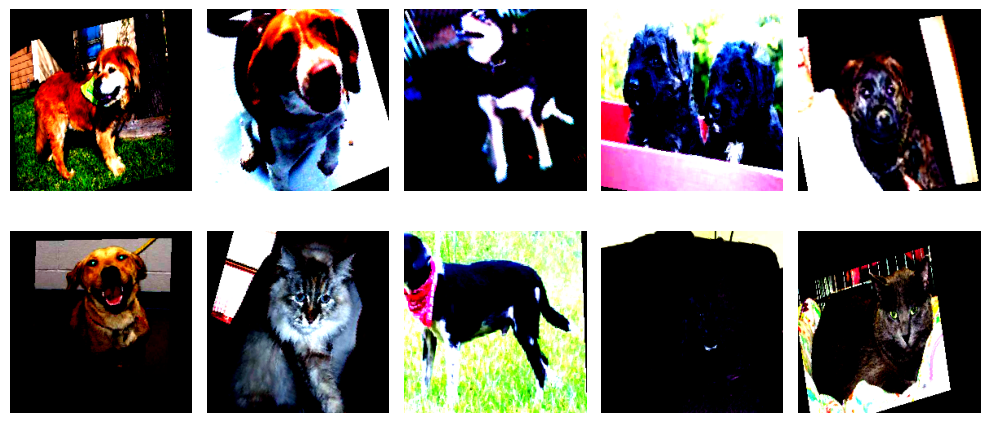

In [19]:
train_loader = get_train_loader()
images, _ = next(iter(train_loader))
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    img = images[i].permute(1, 2, 0).cpu().numpy() # convert to (H, W, C)
    img = img.clip(0, 1) # clip values to [0, 1]
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

#### Without normalization

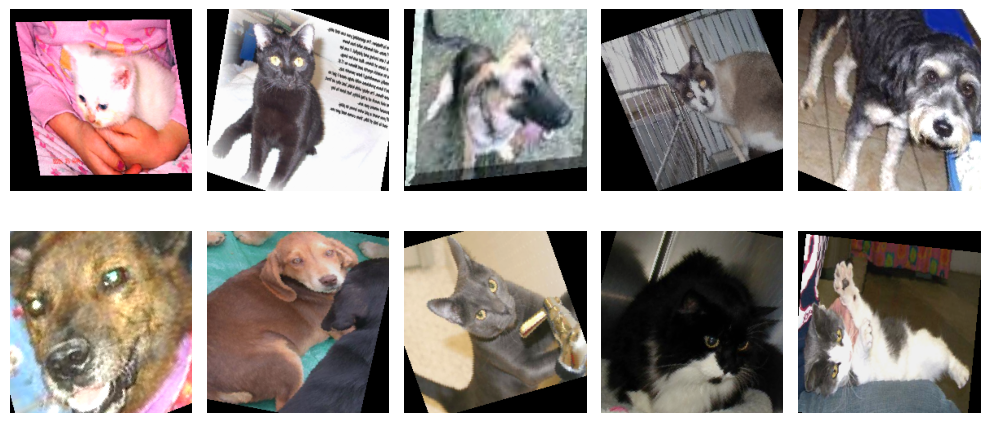

In [20]:
train_loader = get_train_loader()
images, _ = next(iter(train_loader))
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    axes[i // 5, i % 5].imshow(denormalize_image(images[i]).permute(1, 2, 0)) # denormalize and convert to (H, W, C)
    axes[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

## 2. Train a CNN

In [ ]:
test_image = "data/test/cats/cat.1306.jpg"

## Own Model

In [ ]:
net_config1 = {**default_net_config,
    "cv_layers": [
        {"out_channels": 32, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": True},
        {"out_channels": 64, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": True},
        {"out_channels": 128, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": True},
        {"out_channels": 256, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": True},
    ],
    "fc_layers": [
        {"out_features": 256, "batch_norm": True, "dropout_rate": 0.3},
        {"out_features": 128, "batch_norm": True, "dropout_rate": 0.6},
    ]
}

net_config2 = {**default_net_config,
    "cv_layers": [
        {"out_channels": 8, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": True},
        {"out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": True},
        {"out_channels": 32, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": True},
        {"out_channels": 64, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": True},
    ],
    "fc_layers": [
        {"out_features": 512, "batch_norm": True, "dropout_rate": 0.5},
    ]
}

net_config3 = {**default_net_config,
    "cv_layers": [
        {"out_channels": 32, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": False},
        {"out_channels": 64, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": False},
        {"out_channels": 128, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": False},
        {"out_channels": 256, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": False},
    ],
    "fc_layers": [
        {"out_features": 256, "batch_norm": False, "dropout_rate": 0.3},
        {"out_features": 128, "batch_norm": False, "dropout_rate": 0.6},
    ]
}

net_config4 = {**default_net_config,
    "cv_layers": [
        {"out_channels": 64, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": False},
        {"out_channels": 128, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": False},
        {"out_channels": 256, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": False},
        {"out_channels": 512, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": False},
        {"out_channels": 512, "kernel_size": 3, "stride": 1, "padding": 1, "max_pool": 2, "max_pool_stride": 2, "batch_norm": False},
    ],
    "fc_layers": [
        {"out_features": 512, "batch_norm": False, "dropout_rate": 0.4},
        {"out_features": 256, "batch_norm": False, "dropout_rate": 0.2},
    ],
}

train_config1 = {**default_train_config, "weight_decay": 1e-4}
train_config2 = {**default_train_config, "step_size": 25, "gamma": 0.5}
train_config3 = {**default_train_config, "step_size": 25, "gamma": 0.5, "weight_decay": 1e-4}

configs1 = [
    {**default_config, "label": "config1", "net_config": net_config1},
    {**default_config, "label": "config2", "net_config": net_config1, "train_config": train_config1},
    {**default_config, "label": "config3", "net_config": net_config1, "train_config": train_config2},
    {**default_config, "label": "config4", "net_config": net_config2, "train_config": train_config2},
    {**default_config, "label": "config5", "net_config": net_config3},
    {**default_config, "label": "config6", "net_config": net_config4},
    {**default_config, "label": "config7", "net_config": net_config4, "train_config": train_config2},
    {**default_config, "label": "config8", "net_config": net_config4, "train_config": train_config3},
]

results = result_handler(configs1, device)
plot_scores(results)

model = ConvolutionalNetwork(net_config1)
predict(model, "models/config1.pth", device, "results/config1.csv")
plot_summed_feature_maps(model, device, test_image, "results/feature_maps_config1.png")

model = ConvolutionalNetwork(net_config1)
predict(model, "models/config2.pth", device, "results/config2.csv")
plot_summed_feature_maps(model, device, test_image, "results/feature_maps_config2.png")

model = ConvolutionalNetwork(net_config1)
predict(model, "models/config3.pth", device, "results/config3.csv")
plot_summed_feature_maps(model, device, test_image, "results/feature_maps_config3.png")

model = ConvolutionalNetwork(net_config2)
predict(model, "models/config4.pth", device, "results/config4.csv")
plot_summed_feature_maps(model, device, test_image, "results/feature_maps_config4.png")

model = ConvolutionalNetwork(net_config3)
predict(model, "models/config5.pth", device, "results/config5.csv")
plot_summed_feature_maps(model, device, test_image, "results/feature_maps_config5.png")

model = ConvolutionalNetwork(net_config4)
predict(model, "models/config6.pth", device, "results/config6.csv")
plot_summed_feature_maps(model, device, test_image, "results/feature_maps_config6.png")

model = ConvolutionalNetwork(net_config4)
predict(model, "models/config7.pth", device, "results/config7.csv")
plot_summed_feature_maps(model, device, test_image, "results/feature_maps_config7.png")

model = ConvolutionalNetwork(net_config4)
predict(model, "models/config8.pth", device, "results/config8.csv")
plot_summed_feature_maps(model, device, test_image, "results/feature_maps_config8.png")


Experiment: config1
Epoch 1/100 | Train Loss: 0.7466 (acc. 54.65%) | Val Loss: 0.7142 (acc. 56.50%) | Time: 35s
Epoch 2/100 | Train Loss: 0.6597 (acc. 60.80%) | Val Loss: 0.6407 (acc. 66.00%) | Time: 35s
Epoch 3/100 | Train Loss: 0.6409 (acc. 64.65%) | Val Loss: 0.6204 (acc. 66.50%) | Time: 36s
Epoch 4/100 | Train Loss: 0.6173 (acc. 65.25%) | Val Loss: 0.6130 (acc. 66.67%) | Time: 36s
Epoch 5/100 | Train Loss: 0.5931 (acc. 66.50%) | Val Loss: 0.6356 (acc. 68.00%) | Time: 36s
Epoch 6/100 | Train Loss: 0.5972 (acc. 67.65%) | Val Loss: 0.6044 (acc. 67.00%) | Time: 36s
Epoch 7/100 | Train Loss: 0.5714 (acc. 69.50%) | Val Loss: 0.6206 (acc. 67.67%) | Time: 36s
Epoch 8/100 | Train Loss: 0.5702 (acc. 70.65%) | Val Loss: 0.5979 (acc. 70.17%) | Time: 36s


## Transfer Learning

In [ ]:
num_classes = default_config["net_config"]["num_classes"]

model_alexnet = alexnet(weights=AlexNet_Weights.DEFAULT)

# Freeze all parameters/layers except last one
for name, param in model_alexnet.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

# Change last layer to output 2 classes
model_alexnet.classifier[6] = nn.Linear(4096, num_classes)

config_alexnet = {**default_config, "label": "alexnet", "n_epochs": 20}

results = {}
results["alexnet"] = train_model(model_alexnet, device, config_alexnet)
plot_scores(results)

model = AlexNet(num_classes=num_classes)
predict(model, "models/alexnet.pth", device, "results/alexnet.csv")
plot_summed_feature_maps(model, device, test_image, "results/feature_maps_alexnet.png")